In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import xarray as xr
import pandas as pd
import os
import sys
import jinja2
import dataclasses
#import hvplot.xarray
print(sys.path)
import pytropd.functions as tropdf
import pytropd.metrics as tropdm
from own_functions import (vertical_weights, weights, calc_jet_lats, calc_jet_lats_tropd, calc_theta,
    get_setup_from, get_ty_from, get_tmax_from
)
from own_functions import r_air, kappa, kappai, g0, p00, r_e

from visualization import (plot_zm_climatologies, plot_transports, plot_hor_fields, 
    plot_ep_flux_div, plot_EKE_spectral, plot_spectral_vd, plot_hayashi_spectra,
    plot_wave_persistency, plot_theta_profiles, plot_t_profiles, plot_transports,
    plot_theta_u_zm_clim)
from relax_visualization import (Params_HS_PK, Forcing_params, 
    g_func, tteh_cc_tropics, tteh_waves, tteh_mons, relax_submodel
)
import dataclasses
from dataclasses import dataclass

import warnings
warnings.simplefilter(action='ignore')

pplt.rc.update({
    'figure.dpi': 100,
    'figure.figsize': (8,6),
    'savefig.dpi': 150,
})

['/home/b/b381739/masterarbeit', '/home/b/b381739/masterarbeit', '/home/b/b381739/code', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python39.zip', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/lib-dynload', '', '/home/b/b381739/.local/lib/python3.9/site-packages', '/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages']


In [4]:
exp_name='noncnSW90_f070'
ref_name='EMIL_SW90_f070'
plot_format='png'
ylims=[1000,100]

r_air = 287.04
cp = 1003
kappa = r_air/cp
kappai = 1/kappa
g0 = 9.80665
p00 = 1013
r_e = 6.37e6

def calc_theta(ds):
    """
    adds theta as variable to ds
    """
    theta = ds.tm1 * (p00/ds.plev) ** (r_air/cp)
    ds['theta'] = theta
    return ds

def calc_pressure(ds):
    """
    adds p and dp as variables to ds
    """
    ds['p'] = ds.hyam + ds.hybm * ds.aps
    nlevs = ds.lev.size

    #dp_top = (ds.p.isel(lev=0) + ds.p.isel(lev=1).values)/2 - ds.p.isel(lev=0).values
    dp_top = ds.p.isel(lev=0)*0.000001 + ds.p.isel(lev=1).values/2
    dp_mid = ((ds.p.isel(lev=slice(1,nlevs-1)) + ds.p.isel(lev=slice(2,nlevs)).values)/2 -
              (ds.p.isel(lev=slice(0,nlevs-2)).values + ds.p.isel(lev=slice(1,nlevs-1)).values)/2)
    dp_bottom = ds.aps - (ds.p.isel(lev=nlevs-1) + ds.p.isel(lev=nlevs-2).values)/2
    #dp_bottom = ds.p.isel(lev=nlevs-1).values - (ds.p.isel(lev=nlevs-1) + ds.p.isel(lev=nlevs-2).values)/2
    #(dp_bottom_var - dp_bottom.values).plot()
    dp = xr.concat([dp_top, dp_mid, dp_bottom], dim='lev')
    ds['dp'] = dp

    return ds

def plot_settings(ylims=ylims):
    plt.ylim(ylims)
    fig = plt.figure(1)
    fig.set_size_inches(8,6)
    return

def plot_theta_profiles(ds, exp_name, lats=[0,40], fgammas=[0.7], t_bnds=[270,450]):

    fig, ax = plt.subplots(ncols=3, figsize=(14,5))

    z = ds.geopot_p.mean(['time', 'lat'])/9.81
    z = z.sel(plev=slice(10,1000))
    

    ds.theta.mean('time').plot.contourf(ax=ax[0], levels=np.arange(t_bnds[0],t_bnds[1],10))
    for i,lat_sel in enumerate(lats):
        ax[i+1].plot(ds.theta.sel(lat=lat_sel, method='nearest').mean('time'), ds.plev, label=r'$T$')
        ds_sel = ds.sel(lat=lat_sel, method='nearest').mean('time')
        
        for fg in fgammas:
            ax[i+1].plot((ds_sel.tm1.dropna('plev').isel(plev=-1).values - fg * 0.0098 * z)  * (p00/ds.plev) ** (r_air/cp), ds.plev, label=f'$f_{{\gamma}} = {fg:.1f}$')
            
        ax[i+1].set_title(f"lat={ds.sel(lat=lat_sel, method='nearest').lat.values:.2f}")
        ax[i+1].legend()
        ax[i+1].set_xlim(t_bnds)
        ax[i+1].set_yscale('log')

    for a in ax:
        a.set_ylim([1000,ds.plev.min()])
    
    return fig, ax

#dates=['19980102', '19980201', '19980301']
dates=['19980301', '19980401', '19980501']
#dates = ['19980102', '19980201','19980301', '19980401', '19980501']
#dates = ['19990801', '19990901', '19991001', '19991101', '19991201']
#dates = ['20000601', '20000701', '20000801', '20000901', '20001001'] #, '20000601', '20000701', '20000801', '20000901', '20001001']

os.chdir(f'/work/bd1022/b381739/{exp_name}')

ds = xr.open_mfdataset('*vaxtra.nc', combine='by_coords')
ds_emil = xr.open_mfdataset('*emil.nc', combine='by_coords')
ds_relax = xr.open_mfdataset('*relax.nc', combine='by_coords')

ds = calc_theta(ds)
ds_emil = calc_pressure(ds_emil)
"""
os.chdir(f'/work/bd1022/b381739/{ref_name}')
#dates_ref = [ '19990901', '19991001', '19991101']
#dates_ref = [ '19980401', '19980501']
#dates_ref = ['20000101', '20000201', '20000301', '20000401', '20000501'] #, '20000601', '20000701', '20000801', '20000901', '20001001']
dates_ref = dates

ds_list_ref = []
ds_r_list_ref = []
ds_e_list_ref = []
for date in dates_ref:
    ds_ref = xr.open_dataset(f'{ref_name}_{date}_0000_vaxtra.nc')
    ds_relax_ref = xr.open_dataset(f'{ref_name}_{date}_0000_relax.nc')
    ds_emil_ref = xr.open_dataset(f'{ref_name}_{date}_0000_emil.nc')
    
    ds_list_ref.append(ds_ref)
    ds_r_list_ref.append(ds_relax_ref)
    ds_e_list_ref.append(ds_emil_ref)
    
ds_ref = xr.combine_by_coords(ds_list_ref, combine_attrs='drop_conflicts', data_vars='minimal')
ds_relax_ref = xr.combine_by_coords(ds_r_list_ref, combine_attrs='drop_conflicts', data_vars='minimal')
ds_emil_ref = xr.combine_by_coords(ds_e_list_ref, combine_attrs='drop_conflicts', data_vars='minimal')

ds_ref = calc_theta(ds_ref)
ds_emil_ref = calc_pressure(ds_emil_ref)
ds_clim_ref = ds_ref.mean(['lon','time'])

pplt.rc.update({
    'figure.dpi': 100,
    'figure.figsize': (8,6),
    'savefig.dpi': 150,
})
"""
os.chdir(f'/home/b/b381739/plots')

In [5]:
ds

<xarray.Dataset>
Dimensions:    (lat: 64, lon: 128, plev: 90, tbnds: 2, time: 204)
Coordinates:
  * time       (time) datetime64[ns] 1998-01-02 1998-01-03 ... 1998-07-24
  * lon        (lon) float32 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * plev       (plev) float32 0.009946 0.03183 0.05808 ... 967.4 995.7 1.009e+03
  * lat        (lat) float32 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Dimensions without coordinates: tbnds
Data variables:
    YYYYMMDD   (time) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    dt         (time) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    nstep      (time) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    um1        (time, plev, lat, lon) float32 dask.array<chunksize=(30, 90, 64, 128), meta=np.ndarray>
    vm1        (time, plev, lat, lon) float32 dask.array<chunksize=(30, 90, 64, 128), meta=np.ndarray>
    tm1        (time, plev, lat, lon) float32 dask.array<chunksize=(30, 90, 64, 128), meta=np.ndarray>
    vervel     (time, plev, lat, lon) float32 dask.array<chunksize=(30, 90, 64, 128), meta=np.ndarray>
    geopot_p   (time, plev, lat, lon) float32 dask.array<chunksize=(30, 90, 64, 128), meta=np.ndarray>
    aps        (time, lat, lon) float32 dask.array<chunksize=(30, 64, 128), meta=np.ndarray>
    time_bnds  (time, tbnds) datetime64[ns] dask.array<chunksize=(30, 2), meta=np.ndarray>
    theta      (time, plev, lat, lon) float32 dask.array<chunksize=(30, 90, 64, 128), meta=np.ndarray>
Attributes: (12/36)
    MESSy:                    MESSy version d2.55.2-1485-gf32d09f02-dirty_f32...
    MESSy_switch:             version 1.0
    MESSy_channel:            version 2.4.4
    MESSy_tracer:             version 2.6
    MESSy_timer:              version 0.1
    MESSy_qtimer:             version 3.0
    ...                       ...
    operating_user:           Pablo Conrat Fuentes (b381739)
    channel_io_pe:            0
    channel_name:             vaxtra
    channel_file_type:        output
    channel_file_name:        noncnSW90_f070_19980102_0000_vaxtra.nc
    channel_netcdf_lib:       4.8.1 of Feb 16 2022 21:18:58 $

In [11]:
ds_sel = ds.mean(['time', 'lon'])
psi = tropdf.TropD_Calculate_StreamFunction(ds_sel.vm1.values.T, 
                                            ds.lat.values,
                                            ds.plev.values)

ds['psi'] = (['plev', 'lat'], psi.T)

(1000.0, 10.0)

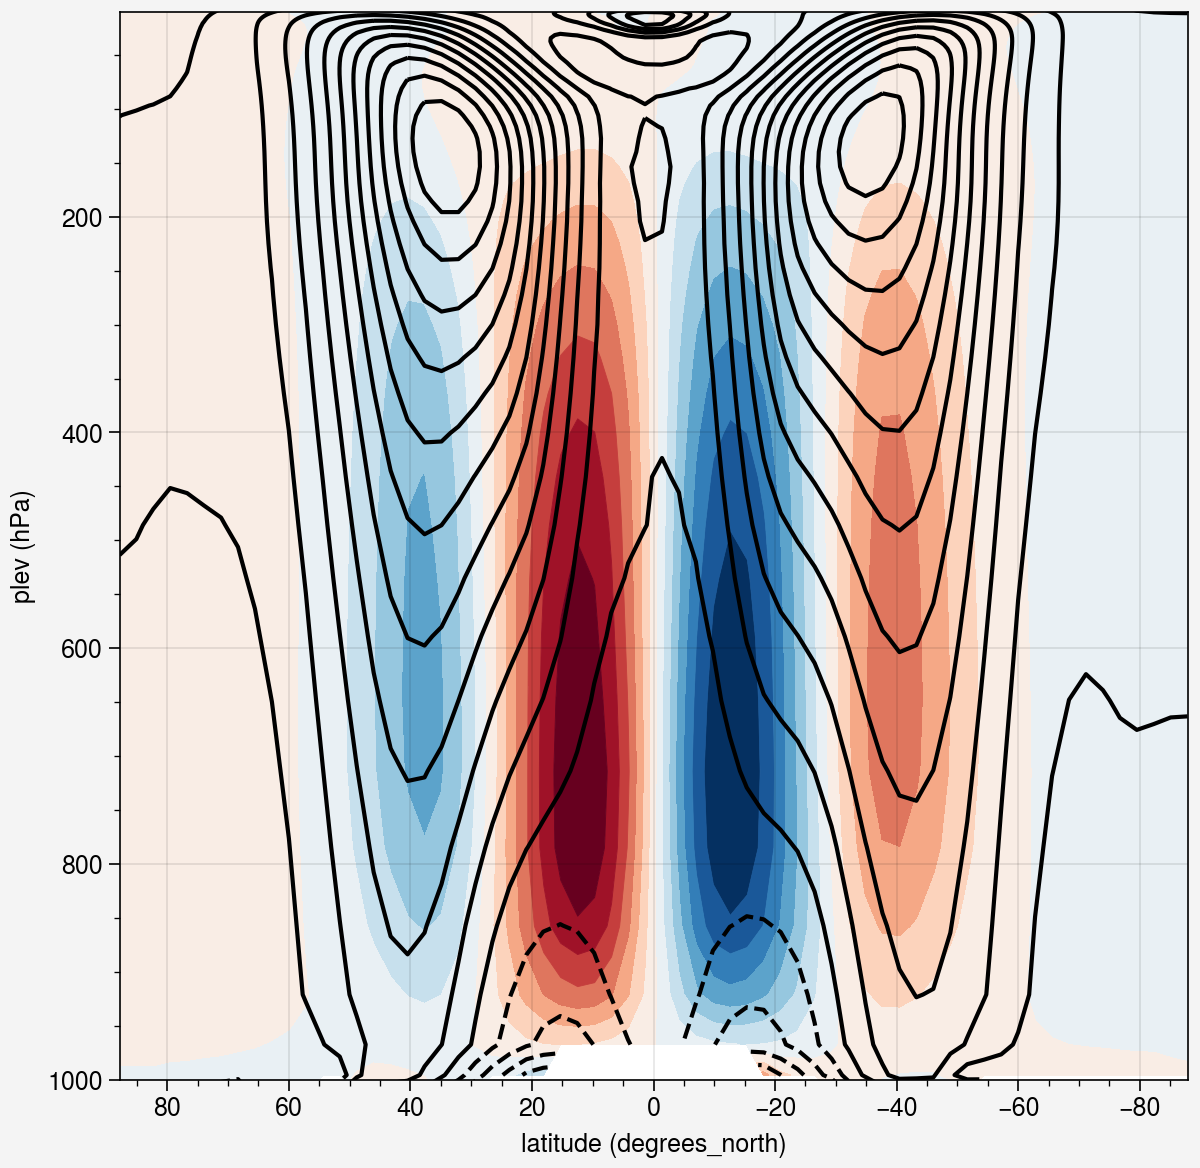

In [17]:
fig, ax = pplt.subplots(figwidth=6)

ax.contour(ds.lat, ds.plev, ds.um1.mean(['time','lon']), levels=16, color='black')
ax.contourf(ds.lat, ds.plev, ds.psi, levels=16)
plt.ylim([1000,10])

(90.0, 60.0)

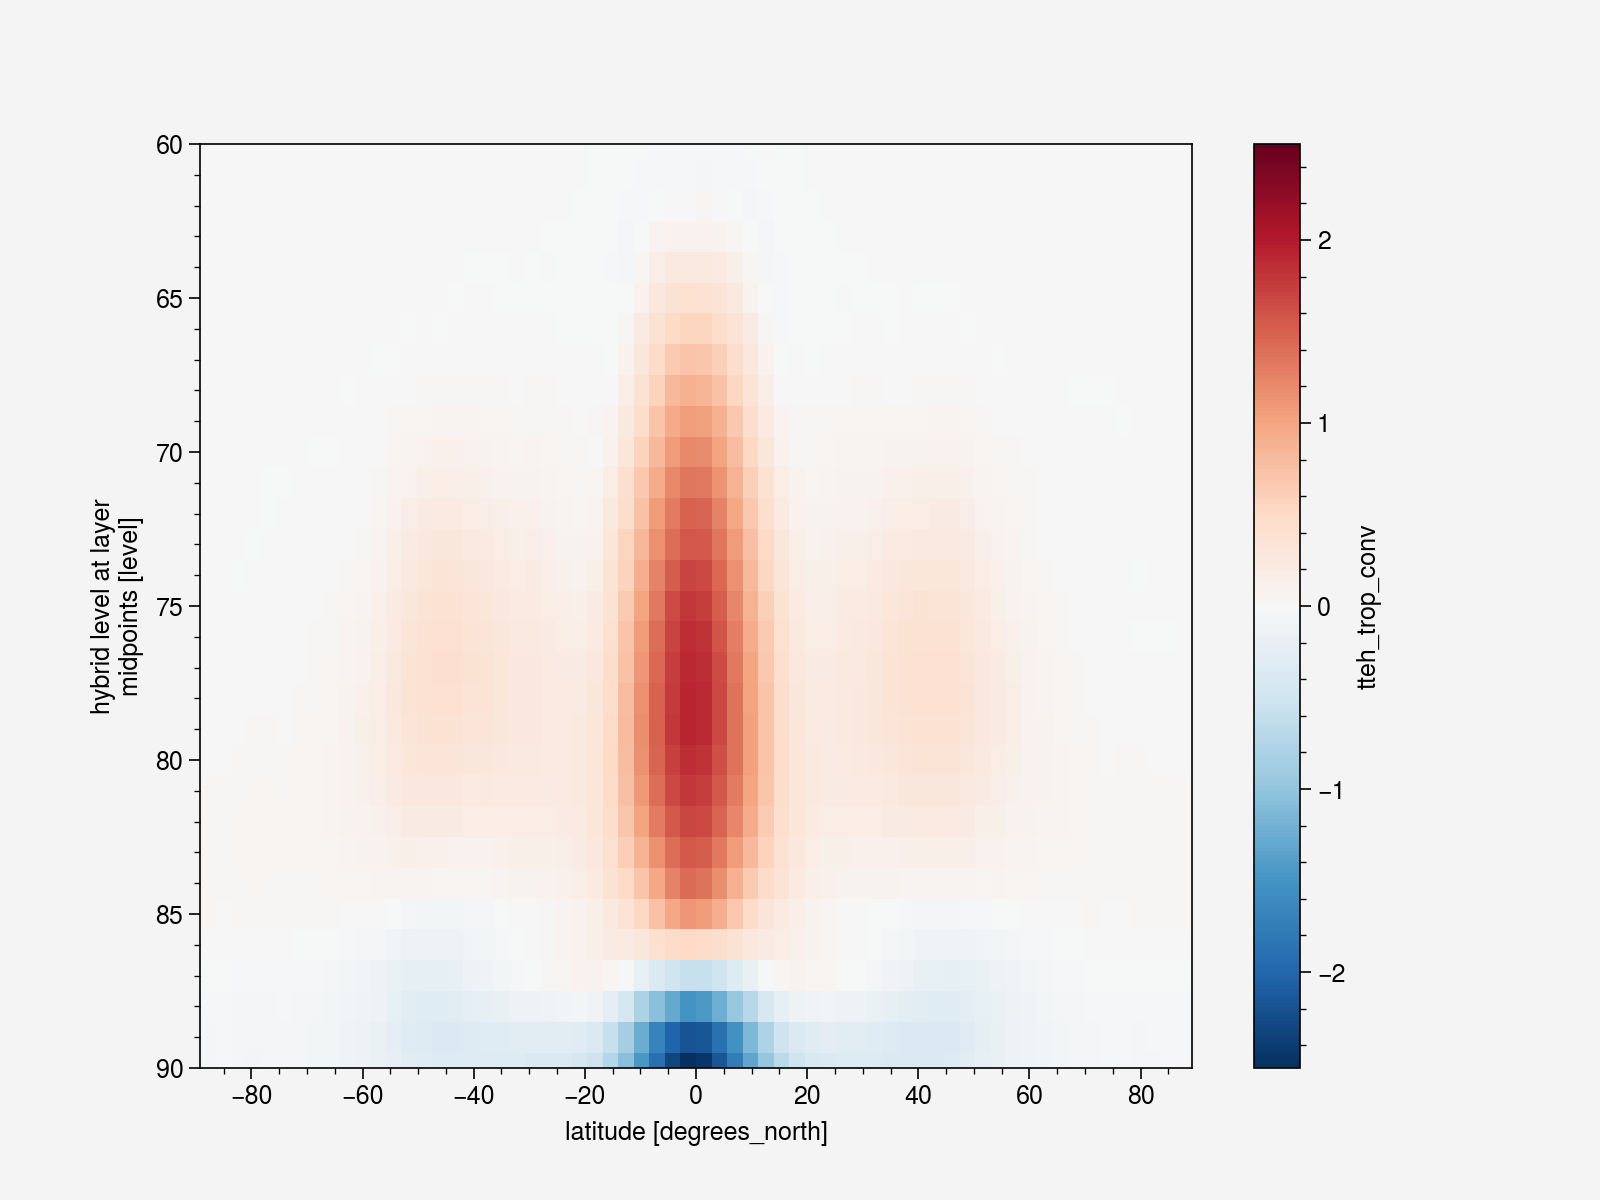

In [20]:
(24 * 3600 * ds_relax.tteh_trop_conv.mean(['lon','time'])).plot()
plt.ylim([90,60])

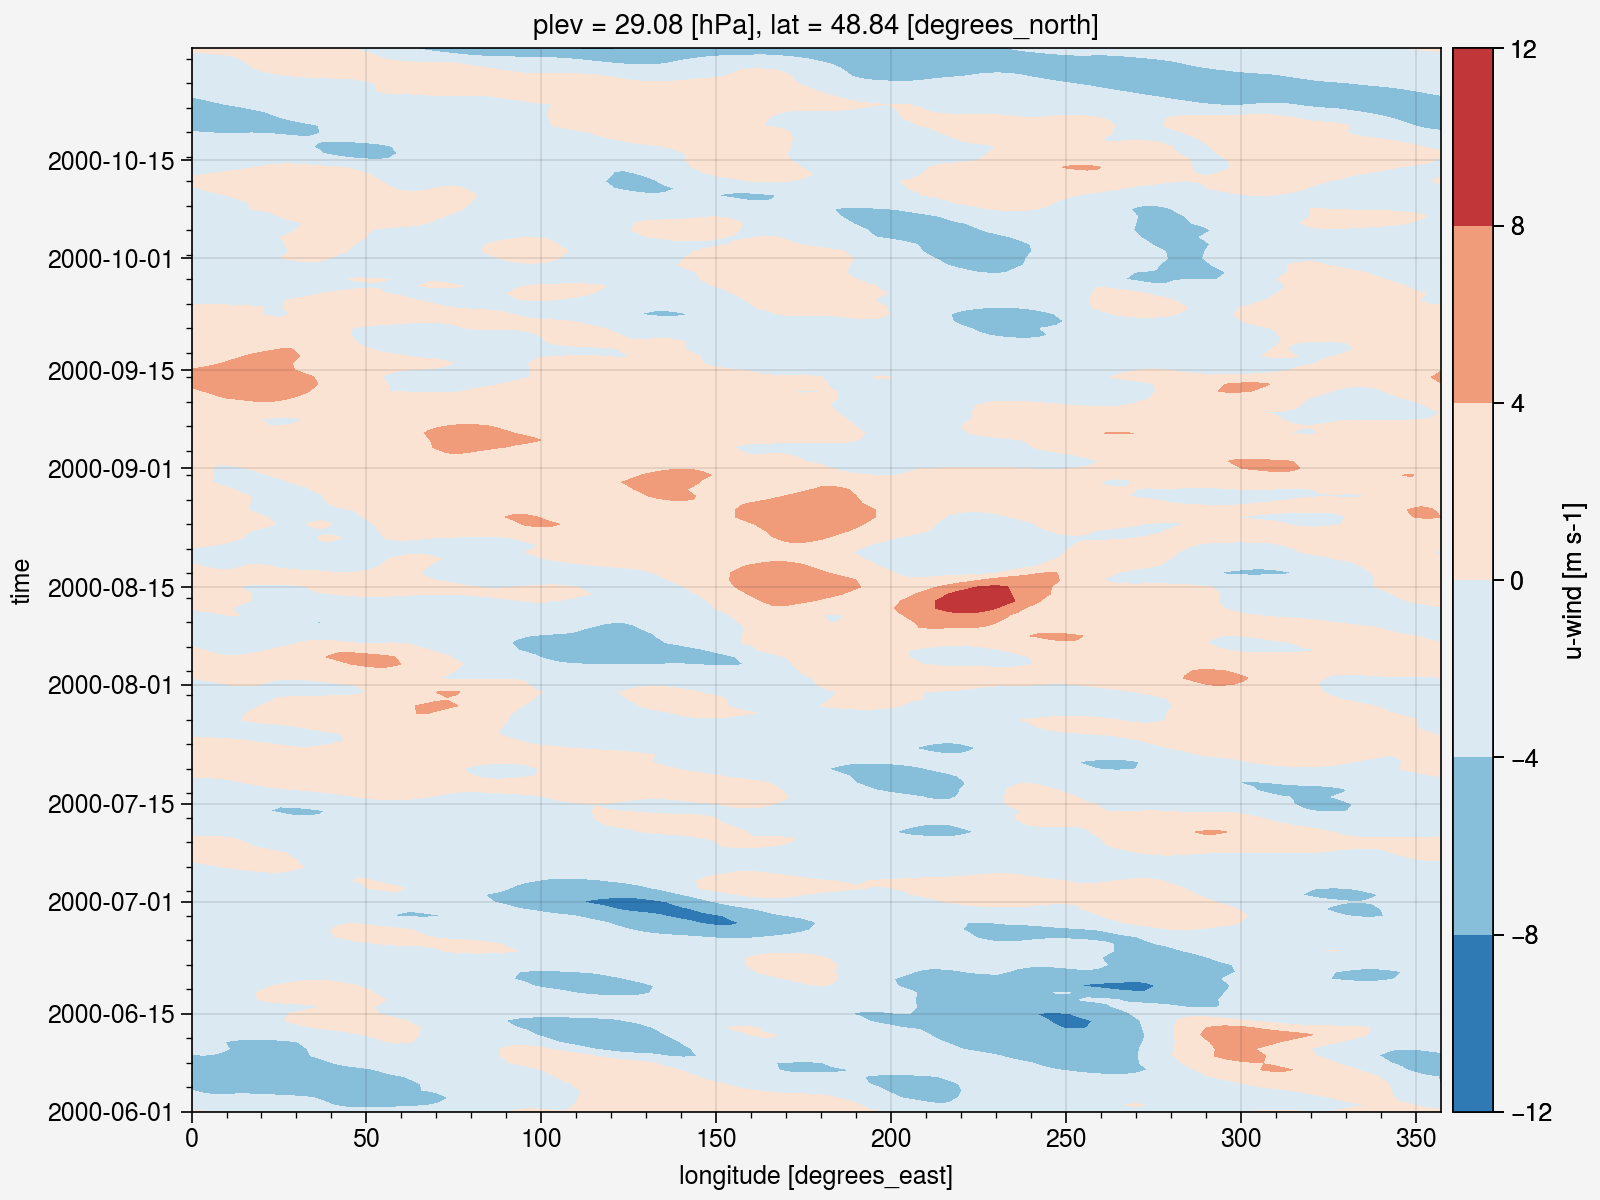

In [11]:
fig, ax = pplt.subplots(figsize=(8,6))

p0=30
deg=50
ds_sel = ds.sel(plev=p0, lat=deg, method='nearest')

ds_sel.um1.plot.contourf(ax=ax)
#ax.pcolormesh(ds_sel.time,ds_sel.lon, ds_sel.um1.T)
fig.savefig(f'{exp_name}_hovmoeller_u{p0}_{deg}n.{plot_format}')  

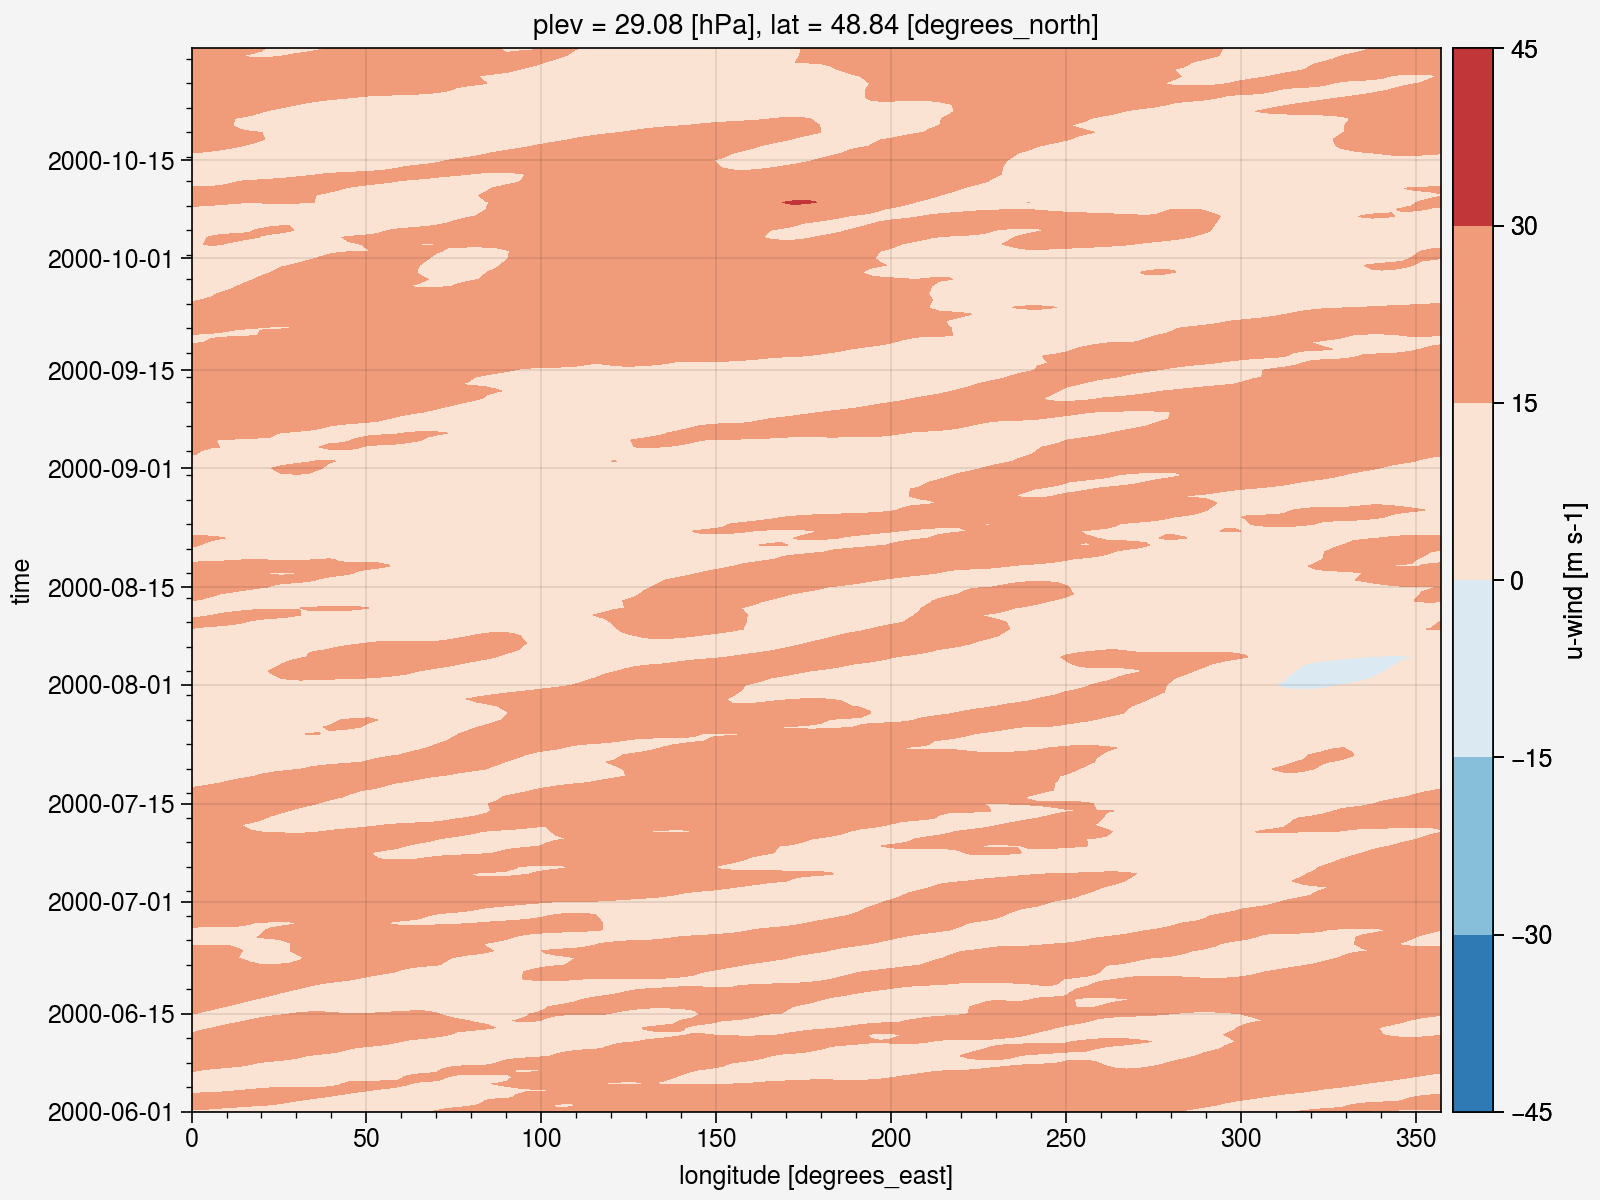

In [12]:
fig, ax = pplt.subplots(figsize=(8,6))

ds_sel = ds_ref.sel(plev=p0, lat=deg, method='nearest')

ds_sel.um1.plot.contourf(ax=ax)
#ax.pcolormesh(ds_sel.time,ds_sel.lon, ds_sel.um1.T)
fig.savefig(f'{ref_name}_hovmoeller_u{p0}_{deg}n.{plot_format}')  